In [4]:
#!pip install datasets 'tensorflow==2.15'
!pip show tensorflow # This notebook was designed for version 2.15 (which seems to be not available), so I'm going to try run it with the default installed version 2.19

Name: tensorflow
Version: 2.19.0
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.12/dist-packages
Requires: absl-py, astunparse, flatbuffers, gast, google-pasta, grpcio, h5py, keras, libclang, ml-dtypes, numpy, opt-einsum, packaging, protobuf, requests, setuptools, six, tensorboard, termcolor, typing-extensions, wrapt
Required-by: dopamine_rl, tensorflow-text, tensorflow_decision_forests, tf_keras


In [5]:
!pip install gensim # Because in Demo1 I use this to resovle the "ModuleNotFoundError: No module named 'gensim'" error
# Note: It forced a re-start after the installation of new versions of numpy,scipy (to be compatible with gensim 4.3.3, the current version of gensim at Oct 2 2025)

In [6]:
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.layers import GRU, Dense, Embedding, Input
import numpy as np
from gensim.models import Word2Vec
# Previously this was from tensorflow.keras.layers.experimental.preprocessing import TextVectorization, but I got the
# ModuleNotFoundError: No module named 'tensorflow.keras.layers.experimental'
# Gemini fix the import. It said "It looks like the TextVectorization layer is no longer in the experimental module in this
# version of TensorFlow. I will update the import statement to fix this."
from tensorflow.keras.layers import TextVectorization # Corrected import
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import Dropout
from datasets import load_dataset

# Dataset creation and preprocessing
max_vocab_size = 25000  # Limit vocabulary size
max_seq_len = 450       # Maximum sequence length
embedding_dim = 150
latent_dim = 512  # Increased latent dimension for GRU
output_dim = 2

# Load the IMDb dataset from Hugging Face
dataset = load_dataset("imdb")

In [7]:
# Train Word2Vec embeddings using gensim
sentences = [text.split() for text in dataset['train']['text']]
word2vec_model = Word2Vec(sentences, vector_size=embedding_dim, window=5, min_count=1, workers=4)

# Create embedding matrix
def create_embedding_matrix(word_index, word2vec_model, embedding_dim):
    embedding_matrix = np.zeros((len(word_index), embedding_dim))
    for word, i in word_index.items():
        if word in word2vec_model.wv:
            embedding_matrix[i] = word2vec_model.wv[word]
    return embedding_matrix

# TextVectorization layer for preprocessing
vectorizer = TextVectorization(
    max_tokens=max_vocab_size,
    output_mode='int',
    output_sequence_length=max_seq_len
)

# Adapt the TextVectorization layer to the training data
vectorizer.adapt(dataset['train']['text'])

# Get the vocabulary and create the embedding matrix
vocab = vectorizer.get_vocabulary()
word_index = {word: idx for idx, word in enumerate(vocab)}
embedding_matrix = create_embedding_matrix(word_index, word2vec_model, embedding_dim)

In [8]:
# Create TensorFlow datasets
train_texts = tf.convert_to_tensor(dataset['train']['text'])
train_labels = tf.convert_to_tensor(dataset['train']['label'])
test_texts = tf.convert_to_tensor(dataset['test']['text'])
test_labels = tf.convert_to_tensor(dataset['test']['label'])

# Vectorize and preprocess text data
def preprocess_texts(text, label):
    text = vectorizer(text)
    label = tf.one_hot(label, depth=2)
    return text, label

train_ds = tf.data.Dataset.from_tensor_slices((train_texts, train_labels))
train_ds = train_ds.map(preprocess_texts).shuffle(10000).batch(256).prefetch(tf.data.AUTOTUNE)

test_ds = tf.data.Dataset.from_tensor_slices((test_texts, test_labels))
test_ds = test_ds.map(preprocess_texts).batch(256).prefetch(tf.data.AUTOTUNE)

In [9]:
# Define the CrossAttention Layer
class CrossAttention(tf.keras.layers.Layer):
    def __init__(self, units, **kwargs):
        super().__init__()
        self.mha = tf.keras.layers.MultiHeadAttention(key_dim=units, num_heads=1, **kwargs)
        self.layernorm = tf.keras.layers.LayerNormalization()
        self.add = tf.keras.layers.Add()

    def call(self, x, context):
        attn_output, attn_scores = self.mha(query=x, value=context, return_attention_scores=True)
        attn_scores = tf.reduce_mean(attn_scores, axis=1)
        self.last_attention_weights = attn_scores
        x = self.add([x, attn_output])  # Residual Connection
        x = self.layernorm(x)
        return x

# Define the RNN with Attention model as a class
class RNNWithAttention(tf.keras.Model):
    def __init__(self, embedding_matrix, max_seq_len, embedding_dim, latent_dim, output_dim):
        super().__init__()
        self.embedding_layer = Embedding(
            input_dim=embedding_matrix.shape[0],
            output_dim=embedding_dim,
            weights=[embedding_matrix],
            trainable=False
        )
        self.encoder_gru = GRU(latent_dim, return_sequences=True, return_state=True,
                               kernel_regularizer=tf.keras.regularizers.l2(1e-4))
        self.dropout = tf.keras.layers.Dropout(0.3)
        self.attention_layer = CrossAttention(units=latent_dim)
        self.output_layer = Dense(output_dim, activation="softmax", kernel_regularizer=tf.keras.regularizers.l2(1e-4))

    # Removed @tf.function decorator
    def call(self, inputs):
        embeddings = self.embedding_layer(inputs)
        encoder_outputs, encoder_state = self.encoder_gru(embeddings)
        encoder_outputs = self.dropout(encoder_outputs)
        # Use tf.expand_dims instead of slicing with tf.newaxis
        attention_outputs = self.attention_layer(tf.expand_dims(encoder_state, axis=1), encoder_outputs)
        outputs = self.output_layer(attention_outputs[:, 0, :])
        return outputs

# Build the model
sentiment_model = RNNWithAttention(
    embedding_matrix=embedding_matrix,
    max_seq_len=max_seq_len,
    embedding_dim=embedding_dim,
    latent_dim=latent_dim,
    output_dim=output_dim
)


# Compile the model
sentiment_model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.CategoricalCrossentropy(),
    metrics=["accuracy"]
)

# Build the model to show summary
sentiment_model.build(input_shape=(None, max_seq_len))
sentiment_model.summary()

# I'm ignoring the following error in the output, because that's what I end up doing in example one and it did not affect the result.
# I wonder if ths time it may affect as he is adding the attention mechanism. Perhaps not because the build method is now to necessary
# in this library is somewhat automated
# This is the error:
# "/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer
# 'rnn_with_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state.
# This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line.
# Make sure to implement a proper `build()` method."

/usr/local/lib/python3.12/dist-packages/keras/src/layers/layer.py:421: UserWarning: `build()` was called on layer 'rnn_with_attention', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(


Model: "rnn_with_attention"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │     3,750,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gru (GRU)                       │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ ?                      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ cross_attention                 │ ?                      │   0 (unbuilt) │
│ (CrossAttention)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 3,750,000 (14.31 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 3,750,000 (14.31 MB)

In [10]:
# Train the model with early stopping
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
history = sentiment_model.fit(
    train_ds,
    validation_data=test_ds,
    epochs=20,
    callbacks=[early_stopping]
)

# Got the following error in line 3 "history = ..."
# OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().
# Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem:
# If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are
# using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using
# an unsupported feature or your source code may not be visible to AutoGraph.
# See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code
# for more information.
# Arguments received by GRU.call():
#  • sequences=tf.Tensor(shape=(None, 450, 150), dtype=float32)
#  • initial_state=None
#  • mask=None
#  • training=False

# Gemini said:
# "It seems there is an issue with how the encoder_state is being indexed for the attention layer within the custom model.
# I will modify the call method to use tf.expand_dims which is generally more compatible with graph execution."
# Gemini tried to fix it by modifying the previous cell from:
# "attention_outputs = self.attention_layer(encoder_state[:, tf.newaxis, :], encoder_outputs)"
# to
# "attention_outputs = self.attention_layer(tf.expand_dims(encoder_state, axis=1), encoder_outputs)"
#
# After the fix I got a new error same line 3 (which seems to call the code in the previous cell)
# #Iterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem:
# If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function.
# If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may
# be using an unsupported feature or your source code may not be visible to AutoGraph.
# See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code
# for more information.
# Arguments received by GRU.call():
#  • sequences=tf.Tensor(shape=(None, 450, 150), dtype=float32)
#  • initial_state=None
#  • mask=None
#  • training=False
#
# Gemini said:
# "It seems the previous fix didn't fully resolve the graph execution issue within the GRU layer.
# I will decorate the call method of the RNNWithAttention model with @tf.function to help TensorFlow build a compatible graph."
# Gemini try another fix by adding the following decorator to the def call(self, inputs) function
# @tf.function
#
# I got another error and I tried again by clearing all the outputs, restarting the session and re-runnings all the cell up to this one
#
# I got the same error and Gemini seemed to be running out of options as it suggested to remove the @tf.function decorator
# , which was the last solution it implemented. I'll just follow the video

Epoch 1/20


OperatorNotAllowedInGraphError: Exception encountered when calling RNNWithAttention.call().

[1min user code:

    File "/tmp/ipython-input-1172322897.py", line 36, in call  *
        encoder_outputs, encoder_state = self.encoder_gru(embeddings)
    File "/usr/local/lib/python3.12/dist-packages/keras/src/utils/traceback_utils.py", line 122, in error_handler  **
        raise e.with_traceback(filtered_tb) from None

    OperatorNotAllowedInGraphError: Exception encountered when calling GRU.call().
    
    [1mIterating over a symbolic `tf.Tensor` is not allowed. You can attempt the following resolutions to the problem: If you are running in Graph mode, use Eager execution mode or decorate this function with @tf.function. If you are using AutoGraph, you can try decorating this function with @tf.function. If that does not work, then you may be using an unsupported feature or your source code may not be visible to AutoGraph. See https://github.com/tensorflow/tensorflow/blob/master/tensorflow/python/autograph/g3doc/reference/limitations.md#access-to-source-code for more information.[0m
    
    Arguments received by GRU.call():
      • sequences=tf.Tensor(shape=(None, 450, 150), dtype=float32)
      • initial_state=None
      • mask=None
      • training=False
[0m

Arguments received by RNNWithAttention.call():
  • inputs=tf.Tensor(shape=(None, 450), dtype=int64)

In [ ]:
# Evaluate the model
results = sentiment_model.evaluate(test_ds)
print("Test Accuracy:", results[1])

# Manual testing
sample_positive = "This was the best movie I have ever seen."
sample_negative = "This was the worst movie I have ever watched."
sample_neutral = "The movie was okay, not great but not terrible."
sample_sarcasm = "Wow, this was such a masterpiece... the actors, the screenplay, I could stay for hours if it wasn't for how bad it was."
sample_irony = "The plot was so riveting, I couldn’t stop yawning."

# Preprocess the samples
sample_positive_vectorized = vectorizer(tf.convert_to_tensor([sample_positive]))
sample_negative_vectorized = vectorizer(tf.convert_to_tensor([sample_negative]))
sample_neutral_vectorized = vectorizer(tf.convert_to_tensor([sample_neutral]))
sample_sarcasm_vectorized = vectorizer(tf.convert_to_tensor([sample_sarcasm]))
sample_irony_vectorized = vectorizer(tf.convert_to_tensor([sample_irony]))

# Predict sentiment
positive_prediction = sentiment_model.predict(sample_positive_vectorized)
negative_prediction = sentiment_model.predict(sample_negative_vectorized)
neutral_prediction = sentiment_model.predict(sample_neutral_vectorized)
sarcasm_prediction = sentiment_model.predict(sample_sarcasm_vectorized)
irony_prediction = sentiment_model.predict(sample_irony_vectorized)

print("Positive Prediction:", positive_prediction)
print("Negative Prediction:", negative_prediction)
print("Neutral Prediction:", neutral_prediction)
print("Sarcasm Prediction:", sarcasm_prediction)
print("Irony Prediction:", irony_prediction)

These are the results he got in the video:
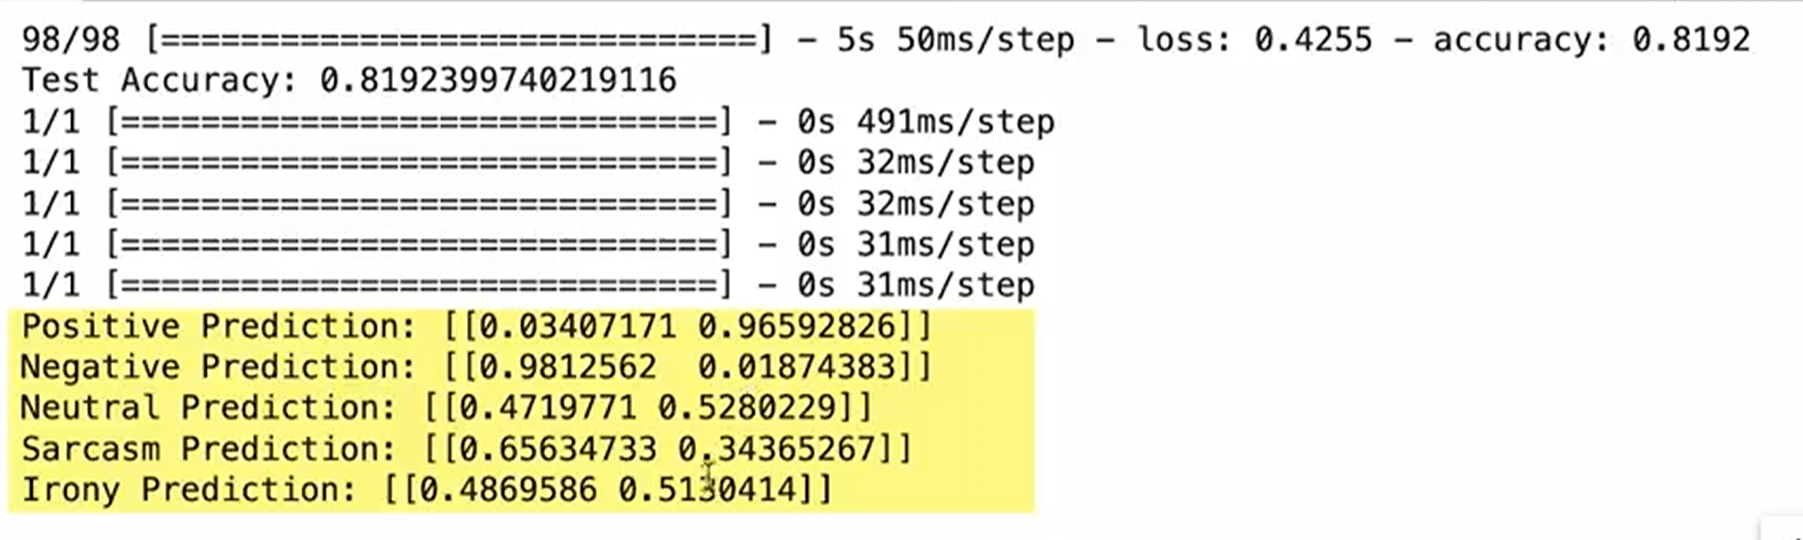